In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import plotly.express as px
import xgboost as xgb

from model import ModelPipeline
import pickle

In [4]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

TIME_FORMAT = '%Y-%m-%d'
DROPNA = True
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']

root_path = Path('./data/')

targets = pd.read_csv(root_path / 'targets.csv')

mortality = pd.read_csv('../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
img_path = Path('./img')
result_data_path = Path('./result_data')
img_path.mkdir(exist_ok=True)
result_data_path.mkdir(exist_ok=True)

PREDICTIVE_SAVE_PATH = result_data_path / 'predictive' 
PREDICTIVE_SAVE_PATH.mkdir(exist_ok=True)

MODEL_SAVE_PATH = result_data_path / 'predictive' / 'models'
MODEL_SAVE_PATH.mkdir(exist_ok=True)

METRICS_SAVE_PATH = result_data_path / 'predictive' / 'metrics'
METRICS_SAVE_PATH.mkdir(exist_ok=True)

IMPORTANCE_SAVE_PATH = result_data_path / 'predictive' / 'importance'
IMPORTANCE_SAVE_PATH.mkdir(exist_ok=True)

IMPORTANT_IMG_SAVE_PATH = img_path / 'predictive' / 'importance'
IMPORTANT_IMG_SAVE_PATH.mkdir(exist_ok=True)

In [5]:
def save_stats(pipeline, save_path, img_save_path, prefix):
    summary_df = pd.DataFrame({
        'factors': pipeline.features,
        'importance_value': pipeline.importance.tolist(),
        'correlation': pipeline.factors_target_corr.tolist(),
    })

    summary_df.sort_values(by='importance_value',ascending=False).to_csv(f'{IMPORTANCE_SAVE_PATH}/{prefix}_features_summary.csv', index=False)
    pickle.dump(pipeline.model_best,  open(f'{MODEL_SAVE_PATH}/{prefix}_model.pkl', 'wb'))
    
    plt.figure(figsize=(20, 7))
    fig = pipeline.model_factors.sort_values(ascending=True).plot(kind='barh')
    plt.tight_layout()
    fig.get_figure().savefig(f'{IMPORTANT_IMG_SAVE_PATH}/{prefix}_factors_importance.jpg')

In [6]:
METRICS_SUMMARY = {
    'train_data': [],
    'feature_set': [],
    'target': [],
    'smape_val': [],
    'smape': [],
    'mae': [],
    'mape': [],
    'median_true_average_value': [],
    'median_pred_average_value': [],
    'std_error': [],
}

def fill_dict(d, smape_val, y_true, y_pred, dataset_name, feature_set_name, target):
    d['smape_val'].append(smape_val)
    d['smape'].append(smape(y_true, y_pred))
    d['mae'].append(mean_absolute_error(y_true, y_pred))
    d['mape'].append(mape(y_true, y_pred))
    d['median_true_average_value'].append(np.median(y_true))
    d['median_pred_average_value'].append(np.median(y_pred))
    d['std_error'].append(np.std(y_true - y_pred))
    d['train_data'].append(dataset_name)
    d['feature_set'].append(feature_set_name)
    d['target'].append(target)
    return d

## Preprocessing

**Prerequisites**: factors_ranking.ipynb notebook has to be run

In [24]:
path_data = result_data_path / 'main' / 'factors_main.csv'
path_features_list = result_data_path / 'factor_ranking' / 'nsfr_final_features_importance.csv'

data = pd.read_csv(path_data,encoding='windows-1252')

data_targets = data.merge(targets[key_columns+['nSFR']],on=key_columns,how='left')
data_targets = data_targets.merge(mortality[key_columns+['transfer_month','transfer_month_year','transfer_season2','transfer_date']],on=key_columns,how='left')
# data_targets.rename(columns={'total_mortality_perc_90':'mortality'},inplace=True)
# data_targets['log_mortality']=np.log(data_targets['mortality'])
# mortality = pd.read_csv('../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')
# mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
# mortality['transport_year']= mortality['transfer_date'].dt.year

all_features = data.columns.difference(key_columns + ['mortality', 'tgc', 'nsfr']).tolist()

df_final_features = pd.read_csv(path_features_list)
final_features = df_final_features.iloc[:,0].tolist()
final_features_top10 = df_final_features.iloc[:10,0].tolist()

In [27]:
def outliers_removal(df, features, coef_std):
    df_output = df.copy()
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        lower_bound = df[feature].mean()-coef_std*df[feature].std()
        upper_bound = df[feature].mean()+coef_std*df[feature].std()
        outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        df_output.loc[outliers, feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
#         print(outliers.sum(),feature)
    return df_output

In [41]:
data_targets.nSFR.describe()

count    1262.000000
mean        0.945493
std         0.224607
min         0.020810
25%         0.843446
50%         0.927490
75%         1.037754
max         1.871816
Name: nSFR, dtype: float64

In [43]:
data_targets.nSFR.quantile(.9)

1.158733354869528

In [28]:
threshold_date = pd.to_datetime('2023-01-01')
max_date = pd.to_datetime('2022-12-31')
train_data = data_targets[data_targets['transfer_date'] < threshold_date]
test_data = data_targets[data_targets['transfer_date'] >= threshold_date]
print(len(train_data),len(test_data))

1226 36


In [29]:
#this change outliers' values with values either mean - 3*std or mean +3*std
train_data=outliers_removal(train_data, all_features, 3)

In [30]:
# display(train_data.head())
# display(test_data.head())

In [31]:
train_data_filled = train_data.copy()
train_data_filled = train_data_filled.fillna(train_data_filled.median())

In [32]:
#data scaling
scaler = RobustScaler()

train_data_scaled = train_data_filled.copy()
train_data_scaled[all_features] = scaler.fit_transform(train_data_scaled[all_features])

test_data_scaled = test_data.copy()
test_data_scaled[all_features]=scaler.transform(test_data[all_features])

In [33]:
test_min_date = test_data['transfer_date'].min().strftime('%Y-%m-%d')
test_max_date = test_data['transfer_date'].max().strftime('%Y-%m-%d')

### Train

-0.09393893474297157
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


smape  smape_val       mae       mape  median_true_average_value  \
0  5.583994   4.497574  0.099816  12.227432                   0.844014   

   median_pred_average_value  std_error  
0                   0.971487   0.086068

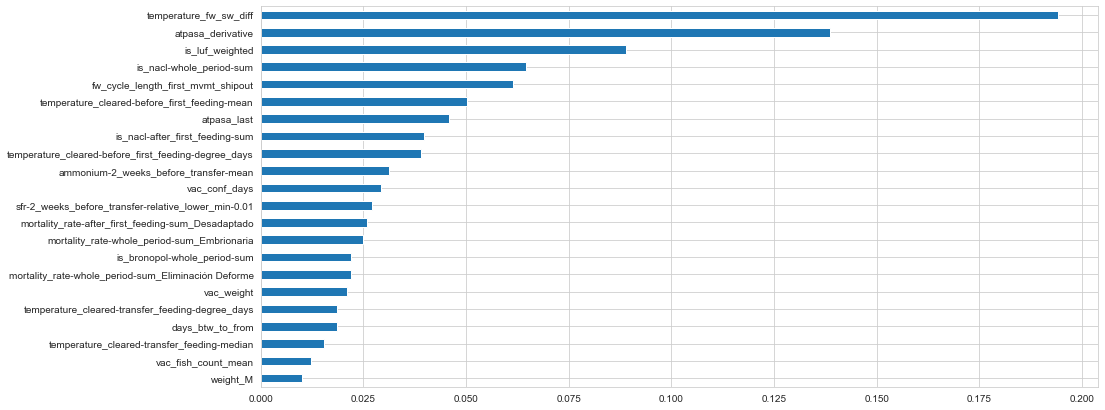

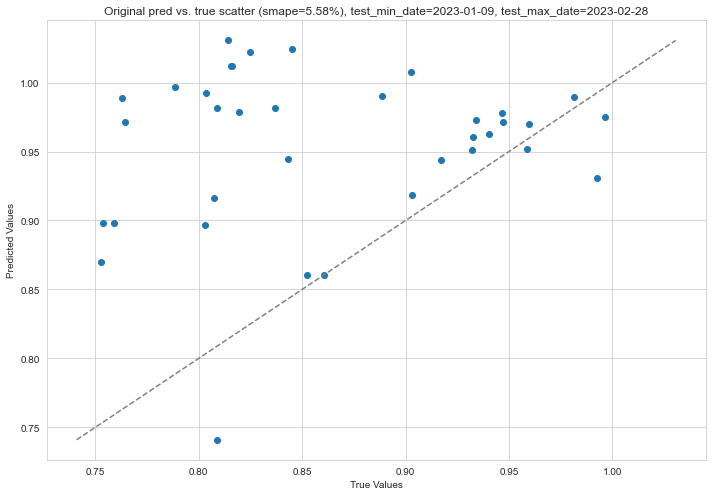

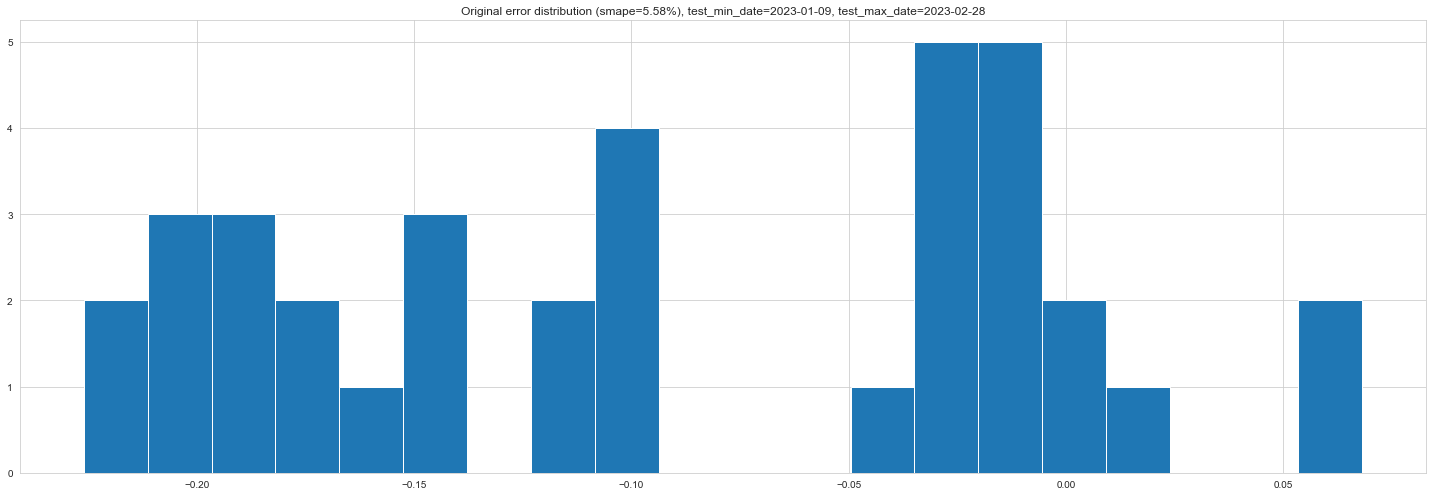

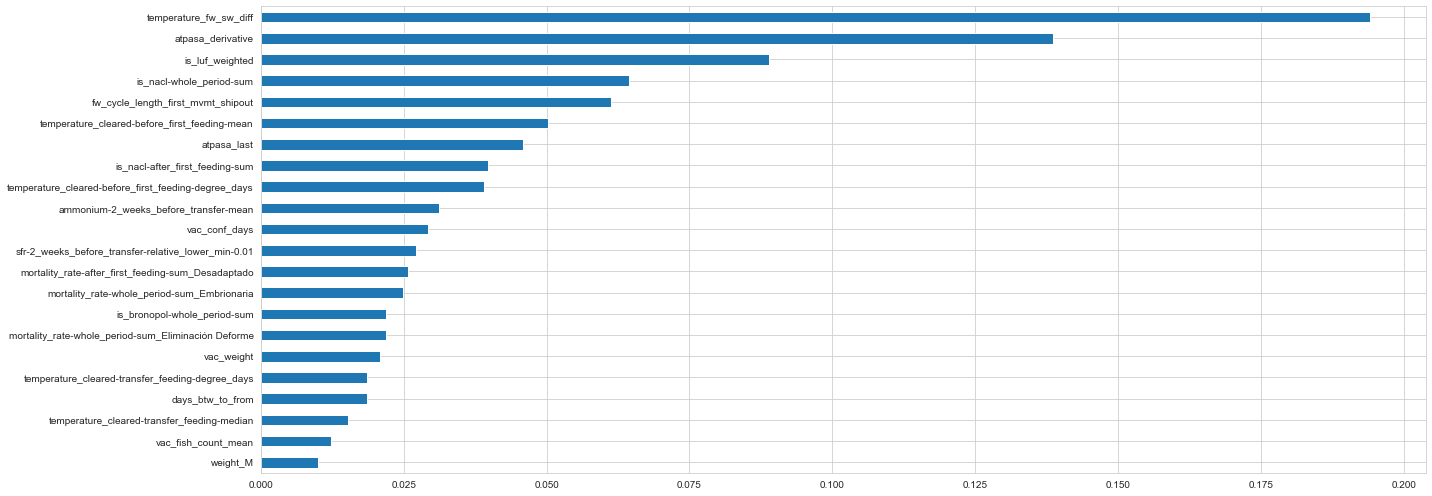

In [50]:
sns.set_style('whitegrid')

data = train_data_scaled.copy()
target = 'nSFR'
features = final_features.copy()

baseline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
baseline.process()

y_pred = baseline.model_best.predict(test_data_scaled[features])
y_true = test_data['nSFR']

metrics = {
    'smape': smape(y_true, y_pred),
    'smape_val': baseline.smape_val,
    'mae': mean_absolute_error(y_true, y_pred),
    'mape': mape(y_true, y_pred),
    'median_true_average_value': np.median(y_true),
    'median_pred_average_value': np.median(y_pred),
    'std_error': np.std(y_true - y_pred)
}

# y_true_perc = y_true * 100
# y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
# diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(10, 7))
# plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%), test_min_date={test_min_date}, test_max_date={test_max_date}")
plt.scatter(x=y_true, y=y_pred)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
fig.savefig(f'{save_path}/{target}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%), test_min_date={test_min_date}, test_max_date={test_max_date}")
plt.hist(diff_original, bins=20)
plt.tight_layout()
fig.savefig(f'{save_path}/{target}_error_distribution.jpg')

df_metrics = pd.DataFrame(metrics, index=[0])
display(df_metrics)
df_metrics.to_csv(f'{METRICS_SAVE_PATH}/{target}_model_metrics.csv',index=False)

save_stats(
    baseline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=target
)

In [47]:
y_pred2=len(y_pred)*[train_data.nSFR.mean()]
y_pred2

[0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078,
 0.9479107070306078]

In [38]:
baseline.model_factors.sort_values(ascending=False)

temperature_fw_sw_diff                                  0.194134
atpasa_derivative                                       0.138630
is_luf_weighted                                         0.088851
is_nacl-whole_period-sum                                0.064480
fw_cycle_length_first_mvmt_shipout                      0.061330
temperature_cleared-before_first_feeding-mean           0.050325
atpasa_last                                             0.045800
is_nacl-after_first_feeding-sum                         0.039836
temperature_cleared-before_first_feeding-degree_days    0.039094
ammonium-2_weeks_before_transfer-mean                   0.031173
vac_conf_days                                           0.029178
sfr-2_weeks_before_transfer-relative_lower_min-0.01     0.027148
mortality_rate-after_first_feeding-sum_Desadaptado      0.025819
mortality_rate-whole_period-sum_Embrionaria             0.024954
is_bronopol-whole_period-sum                            0.021901
mortality_rate-whole_peri